# Backtesting with zipline - Pipeline API with Custom Data

> This notebook requires the `conda` environment `backtest`. Please see the [installation instructions](../installation/README.md) for running the latest Docker image or alternative ways to set up your environment.

## Imports & Settings

In [1]:
from pathlib import Path
from collections import defaultdict
from time import time
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO, WARNING

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader
from trading_calendars import get_calendar

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [2]:
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
np.random.seed(42)
idx = pd.IndexSlice

In [3]:
results_path = Path('results', 'cnn_for_trading')
if not results_path.exists():
    results_path.mkdir()

## Alphalens Analysis

In [4]:
DATA_STORE = Path('..', 'data', 'assets.h5')

In [5]:
def get_trade_prices(tickers):
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    prices = prices.loc[idx[tickers, '2010':'2018'], 'adj_open']
    return (prices
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [6]:
predictions = (pd.read_hdf(results_path / 'predictions.h5', 'predictions')
               .iloc[:, :4]
               .mean(1)
               .to_frame('prediction'))

In [7]:
factor = (predictions
          .unstack('symbol')
          .asfreq('D')
          .dropna(how='all')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())
tickers = factor.index.get_level_values('symbol').unique()

In [8]:
factor.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 889728 entries, (Timestamp('2011-04-27 00:00:00+0000', tz='UTC'), 'A') to (Timestamp('2017-12-28 00:00:00+0000', tz='UTC'), 'UAL')
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   prediction  889728 non-null  float32
dtypes: float32(1)
memory usage: 6.9+ MB


In [9]:
trade_prices = get_trade_prices(tickers)

In [10]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2072 entries, 2010-01-04 00:00:00+00:00 to 2018-03-27 00:00:00+00:00
Columns: 603 entries, A to TWTR
dtypes: float64(603)
memory usage: 9.5 MB


In [11]:
# 에러시 실행
factor.index.names = ['date','asset']

In [12]:
factor = factor.unstack('asset').resample('D').last().stack('asset')

In [13]:
trade_prices = trade_prices.resample('D').last()

In [14]:
trade_prices.fillna(method='pad', inplace=True)
trade_prices.fillna(method='bfill', inplace=True)

In [15]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21)).sort_index()
factor_data.info()

Dropped 32.5% entries from factor data: 0.0% in forward returns computation and 32.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 600903 entries, (Timestamp('2011-04-27 00:00:00+0000', tz='UTC', freq='C'), 'A') to (Timestamp('2017-07-28 00:00:00+0000', tz='UTC', freq='C'), 'UAL')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               600903 non-null  float64
 1   5D               600903 non-null  float64
 2   10D              600903 non-null  float64
 3   21D              600903 non-null  float64
 4   factor           600903 non-null  float32
 5   factor_quantile  600903 non-null  float64
dtypes: float32(1), float64(5)
memory usage: 27.6+ MB


In [16]:
factor_data

1D        5D       10D       21D  \
date                      asset                                           
2011-04-27 00:00:00+00:00 A      0.009230  0.012841  0.000201  0.042135   
                          AAL    0.003432  0.030892  0.090389  0.118993   
                          AAP   -0.000605 -0.014833 -0.015892 -0.028303   
                          AAPL   0.001704  0.005199  0.004824 -0.011872   
                          ABC   -0.024182 -0.023945 -0.017307 -0.003082   
...                                   ...       ...       ...       ...   
2017-07-28 00:00:00+00:00 TWX    0.000000 -0.005256 -0.003310 -0.015283   
                          TXN    0.000000  0.005815  0.014351 -0.008536   
                          TXT    0.000000  0.000406  0.001015 -0.030254   
                          UAA    0.000000 -0.044216 -0.043702 -0.122365   
                          UAL    0.000000 -0.015187 -0.004819 -0.054761   

                                   factor  factor_quantile  
date                      asset                             
2011-04-27 00:00:00+00:00 A     -0.000402              2.0  
                          AAL   -0.000429              1.0  
                          AAP   -0.000391              4.0  
                          AAPL  -0.000385              5.0  
                          ABC   -0.000423              1.0  
...                                   ...              ...  
2017-07-28 00:00:00+00:00 TWX    0.000479              1.0  
                          TXN    0.000482              3.0  
                          TXT    0.000481              2.0  
                          UAA    0.000497              5.0  
                          UAL    0.000496              5.0  

[600903 rows x 6 columns]

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.006551,0.001692,0.000605,0.000674,121314,20.188616
2.0,-0.000724,0.001715,0.000644,0.000670,120214,20.005558
3.0,-0.000674,0.001732,0.000662,0.000671,119275,19.849293
4.0,-0.000590,0.001791,0.000678,0.000671,119831,19.941821
5.0,-0.000454,0.087886,0.000738,0.001045,120269,20.014711


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,-0.011,0.024,-0.005,-0.068
beta,0.118,0.130,0.160,0.199
Mean Period Wise Return Top Quantile (bps),-0.014,-0.888,-0.431,-0.420
Mean Period Wise Return Bottom Quantile (bps),-0.801,-0.071,-0.022,-0.047
Mean Period Wise Spread (bps),0.787,-1.252,-0.462,-0.424


Information Analysis


,1D,5D,10D,21D
IC Mean,0.003,-0.001,-0.001,0.001
IC Std.,0.135,0.143,0.137,0.127
Risk-Adjusted IC,0.024,-0.004,-0.007,0.004
t-stat(IC),NaN,NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN,NaN
IC Skew,NaN,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN,NaN


TypeError: object of type 'float' has no len()

<Figure size 432x288 with 0 Axes>

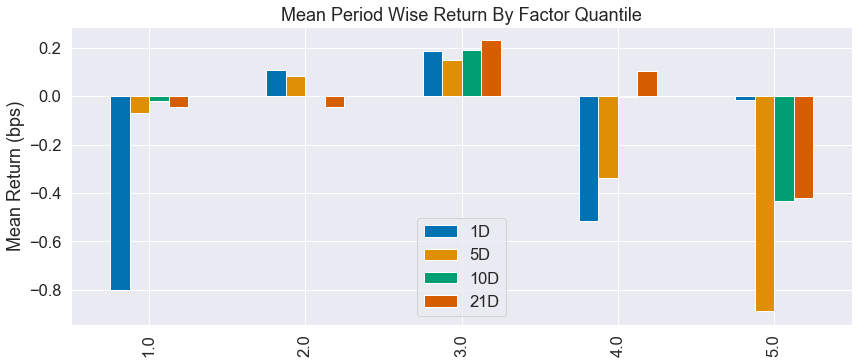

In [17]:
create_summary_tear_sheet(factor_data);

### Load zipline extensions

Only need this in notebook to find bundle.

In [18]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [19]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=WARNING)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [20]:
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 10

## Load Data

### Quandl Wiki Bundel

In [21]:
bundle_data = bundles.load('quandl')

### ML Predictions

In [22]:
def load_predictions(bundle):
    predictions = (pd.read_hdf(results_path / 'predictions.h5', 'predictions')
                   .iloc[:, :4]
                   .mean(1)
                   .to_frame('prediction'))
    tickers = predictions.index.get_level_values('symbol').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('symbol')
            .rename(columns=ticker_map)
            .prediction
            .tz_localize('UTC')), assets

In [23]:
predictions, assets = load_predictions(bundle_data)

In [24]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1680 entries, 2011-04-27 00:00:00+00:00 to 2017-12-28 00:00:00+00:00
Columns: 603 entries, 0 to 2907
dtypes: float32(603)
memory usage: 3.9 MB


### Define Custom Dataset

In [25]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

### Define Pipeline Loaders

In [26]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

### Custom ML Factor

In [27]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, predictions):
        out[:] = predictions

### Create Pipeline

In [28]:
def compute_signals():
    signals = MLSignal()
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS),
        'shorts': signals.bottom(N_SHORTS)},
            screen=StaticAssets(assets))

## Initialize Algorithm

In [29]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.longs = context.shorts = None
    set_slippage(slippage.FixedSlippage(spread=0.00))
#     set_commission(commission.PerShare(cost=0.001, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
#                       date_rules.week_start(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

In [30]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    longs = pipeline_output('signals').longs.astype(int)
    shorts = pipeline_output('signals').shorts.astype(int)
    holdings = context.portfolio.positions.keys()
    
    if longs.sum() > MIN_POSITIONS and shorts.sum() > MIN_POSITIONS:
        context.longs = longs[longs!=0].index
        context.shorts = shorts[shorts!=0].index
        context.divest = holdings - set(context.longs) - set(context.shorts)
    else:
        context.longs = context.shorts = pd.Index([])
        context.divest = set(holdings)

## Define Rebalancing Logic

In [31]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
          
    for stock in context.divest:
        order_target(stock, target=0)
    
#     log.warning('{} {:,.0f}'.format(len(context.portfolio.positions), context.portfolio.portfolio_value))
    if not (context.longs.empty and context.shorts.empty):
        for stock in context.shorts:
            order_target_percent(stock, -1 / len(context.shorts) / 2)
        for stock in context.longs:
            order_target_percent(stock, 1 / len(context.longs))

## Record Data Points

In [32]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## Run Algorithm

In [33]:
dates = predictions.index.get_level_values('date')
start_date, end_date = dates.min(), dates.max()

In [34]:
print('Start: {}\nEnd:   {}'.format(start_date.date(), end_date.date()))

Start: 2011-04-27
End:   2017-12-28


In [35]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e5,
                        data_frequency='daily',
                        bundle='quandl',
                        custom_loader=signal_loader)  # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[2021-05-12 04:48:13.126507]: WARNING: _can_order_asset: Cannot place order for BEAM, as it has de-listed. Any existing positions for this asset will be liquidated on 2014-05-01 00:00:00+00:00.
[2021-05-12 04:48:34.186636]: WARNING: _can_order_asset: Cannot place order for FST, as it has de-listed. Any existing positions for this asset will be liquidated on 2014-12-16 00:00:00+00:00.
[2021-05-12 04:48:38.258785]: WARNING: _can_order_asset: Cannot place order for SWY, as it has de-listed. Any existing positions for this asset will be liquidated on 2015-01-30 00:00:00+00:00.
[2021-05-12 04:48:40.169302]: WARNING: _can_order_asset: Cannot place order for NU, as it has de-listed. Any existing positions for this asset will be liquidated on 2015-02-19 00:00:00+00:00.
[2021-05-12 04:48:52.631015]: WARNING: _can_order_asset: Cannot place order for MCP, as it has de-listed. Any existing positions for this asset will be liquidated on 2015-06-25 00:00:00+00:00.
[2021-05-12 04:48:54.547720]: WARNI

Duration: 236.00s


## PyFolio Analysis

In [36]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [37]:
benchmark = web.DataReader('SP500', 'fred', '2010', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

In [47]:
returns.dropna(inplace=True)

### Custom Plots

In [52]:
LIVE_DATE = '2018-01-01'

In [53]:
returns = returns.resample('D').last()

In [54]:
benchmark = benchmark.resample('D').last()

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: DatetimeIndex(['2011-04-27 00:00:00+00:00', '2011-04-28 00:00:00+00:00',\n               '2011-04-29 00:00:00+00:00', '2011-04-30 00:00:00+00:00',\n               '2011-05-01 00:00:00+00:00',\n               ...\n               '2011-05-07 00:00:00+00:00', '2011-05-08 00:00:00+00:00',\n               '2011-05-09 00:00:00+00:00', '2011-05-10 00:00:00+00:00',\n               '2011-05-11 00:00:00+00:00'],\n              dtype='datetime64[ns, UTC]', length=15, freq='D'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

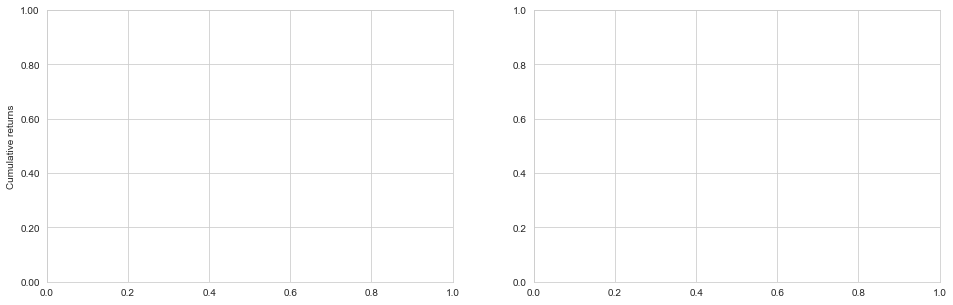

In [55]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date=LIVE_DATE,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                     ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout()
fig.savefig((results_path / 'pyfolio_out_of_sample').as_posix(), dpi=300)

### Tear Sheets

In [ ]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          round_trips=True)